# Q-learning Hyperparameters

Lets analyze how SARSA responds to changes in hyperparameters. Here we will focus in the learning rate $\alpha$ and the exploration rate $\epsilon$, and will try to compare results in multiple worlds. We will consider the online performance of the alforithm as our objective, in the sense of maximizing the average rewards the agent gets. This target is a natural target for SARSA, since it's an on-policy learning algorithm.

We will start by considering the average results of training rounds consisting of 200 episodes, which are more then enough for the agent to find a good(but not necessarily optimal though) police. We will also look at the performance on the final 10 episodes, since they should indicate how well the agent would perform if it needed to continue doing this task. 

Our goal is not to explore these values in great depth, but rather just to get a good idea of what should be good ranges for our problem, and how they influence the agent performance. It is also not clear how this parameters performance may change from world to world; so we will look at some different worlds to get a general idea. 

Reward may be viewed as an arbitrary choice for target, and our goal could be to just minimize number of steps. This could easily be achieved by a minor change in the reward function, however our basic definition should lead to some interesting cases as we will see.

In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.agents.sarsa_agent import SarsaAgent
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action
from notebooks.utils.experimentation import get_exp_results, get_results
from notebooks.utils.worlds import small_world_01, small_world_02, medium_world_01, large_world_01
from notebooks.utils.basics import basic_actions, basic_reward

np.random.seed(13)

## Medium World

We will start by exploring results in a medium sized world. 

In [2]:
training_rounds=100
episodes=200

print(get_world_str(medium_world_01))

5                █  ✘ 

4    █     █          

3    █     █  █  █    

2    █     ☠          

1    █     ☠     ☠    

0 ⚐              ☠    

  0  1  2  3  4  5  6 


In [3]:
def print_summary(results):
    average_rewards_l10 = {key: (np.mean(results[key][0][-10:]))for key in results}
    average_rewards = {key: (np.mean(results[key][0]))for key in results}

    print("Average reward on rounds")
    for k, v in sorted(average_rewards.items(), key=lambda item: item[1], reverse = True):
        print(f"{k}: {v:.2f}")

    print("\nAverage reward on last 10 episodes")
    for k, v in sorted(average_rewards_l10.items(), key=lambda item: item[1],  reverse = True):
        print(f"{k}: {v:.2f}")

In [4]:
base_arguments = {'world': medium_world_01, 'reward_function': basic_reward, 'actions': basic_actions}
arguments = {'alpha': [0.1, 0.3, 0.7, 1], 'epsilon': [0.0003, 0.001, 0.003, 0.01, 0.03]}

results = get_exp_results(SarsaAgent, base_arguments, arguments, episodes, training_rounds) 

print_summary(results)

Average reward on rounds
{'alpha': 1, 'epsilon': 0.001}: -28.93
{'alpha': 1, 'epsilon': 0.0003}: -29.10
{'alpha': 0.7, 'epsilon': 0.0003}: -29.89
{'alpha': 0.7, 'epsilon': 0.001}: -30.00
{'alpha': 1, 'epsilon': 0.003}: -30.36
{'alpha': 0.7, 'epsilon': 0.003}: -31.18
{'alpha': 0.7, 'epsilon': 0.01}: -32.43
{'alpha': 0.7, 'epsilon': 0.03}: -33.81
{'alpha': 1, 'epsilon': 0.03}: -34.30
{'alpha': 0.3, 'epsilon': 0.0003}: -35.16
{'alpha': 1, 'epsilon': 0.01}: -35.20
{'alpha': 0.3, 'epsilon': 0.001}: -36.83
{'alpha': 0.3, 'epsilon': 0.003}: -37.05
{'alpha': 0.3, 'epsilon': 0.01}: -38.59
{'alpha': 0.3, 'epsilon': 0.03}: -41.37
{'alpha': 0.1, 'epsilon': 0.0003}: -69.15
{'alpha': 0.1, 'epsilon': 0.001}: -69.70
{'alpha': 0.1, 'epsilon': 0.01}: -70.23
{'alpha': 0.1, 'epsilon': 0.003}: -70.84
{'alpha': 0.1, 'epsilon': 0.03}: -73.88

Average reward on last 10 episodes
{'alpha': 0.3, 'epsilon': 0.0003}: -11.00
{'alpha': 0.3, 'epsilon': 0.001}: -11.00
{'alpha': 0.7, 'epsilon': 0.0003}: -11.00
{'alpha'

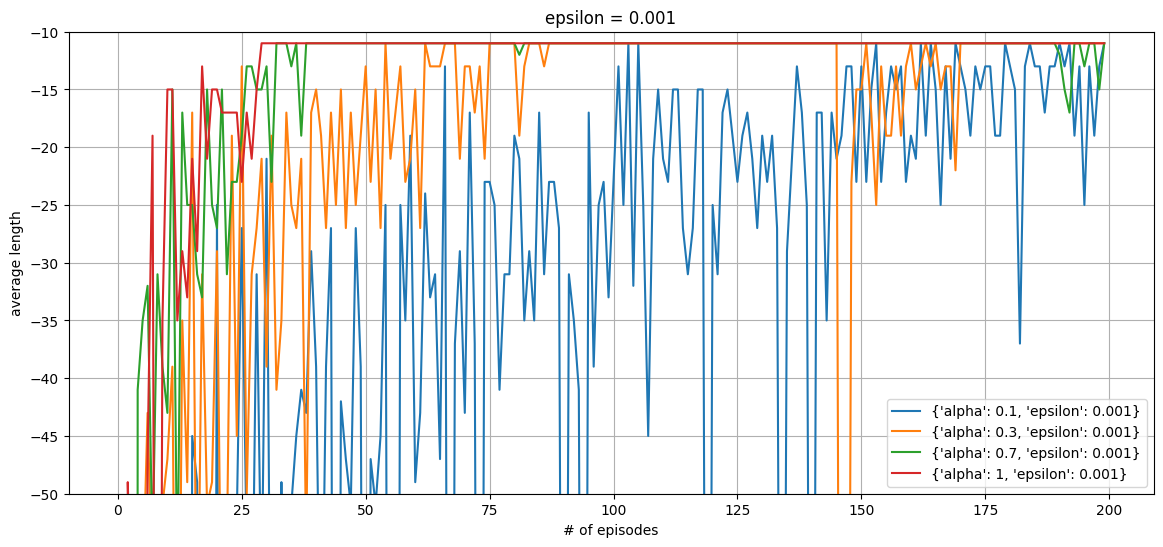

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))

for k, v in results.items():
    if "'epsilon': 0.001" in k:
        ax.plot(v[0], label=k)

ax.set(xlabel="# of episodes", ylabel="average length", ylim=[-50, -10])
ax.grid()
ax.legend(loc="lower right")
ax.set_title('epsilon = 0.001')


plt.show()

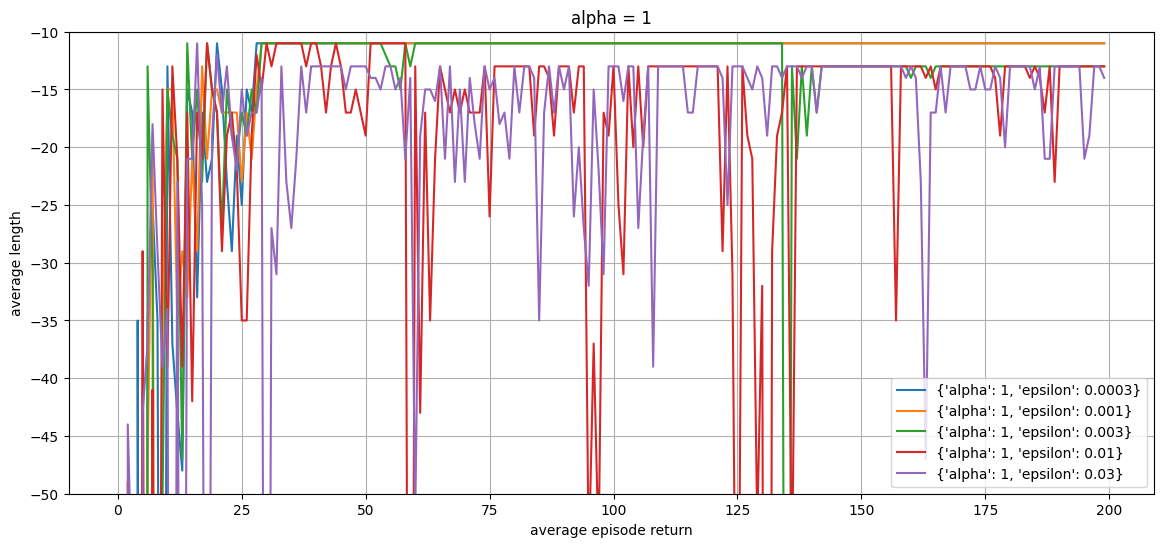

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

for k, v in results.items():
    if "'alpha': 1" in k:
        ax.plot(v[0], label=k)

ax.set(xlabel="average episode return", ylabel="average length", ylim=[-50, -10])
ax.grid()
ax.legend(loc="lower right")
ax.set_title('alpha = 1')

plt.show()

in general it seems to be the case that high values of $\alpha$ lead to faster learning, while small values of $\epsilon$ are related to a better performance on final rounds. This makes some sense, however it seems a little too simplistic to be correct. So lets take a closer look.

In [7]:
agent = SarsaAgent(
    world=medium_world_01,
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=1,
    epsilon=0.001,
)

episode_lengths, episode_returns = agent.train(episodes=200)
pi_r = get_policy_rec(agent.policy, medium_world_01, agent.actions)
print(get_policy_rec_str(pi_r, medium_world_01))

 →  →  →  →  ↓  █  ✘ 

 ↑  █  ↑  █  →  →  ↑ 

 ↑  █  ↑  █  █  █  ↑ 

 ↑  █  ↑  ☠  →  →  ↑ 

 ↑  █  ↑  ☠  ↑  ☠  ↓ 

 →  →  →  →  ↑  ☠  ↑ 




Notice that for this parameters the agent prefers the shorter, but riskier, path. This doesn't look like the optimal path for an on policy agent( although such path depends on $\epsilon$), and I would expect the agent to change behaviour with extra rounds.

In [8]:
agent = SarsaAgent(
    world=medium_world_01,
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=1,
    epsilon=0.001,
)

episode_lengths, episode_returns = agent.train(episodes=20000)
pi_r = get_policy_rec(agent.policy, medium_world_01, agent.actions)
print(get_policy_rec_str(pi_r, medium_world_01))

 →  →  →  →  ↓  █  ✘ 

 ↑  █  ↑  █  →  →  ↑ 

 ↑  █  ↓  █  █  █  ↑ 

 ↑  █  ↑  ☠  ↑  →  ↑ 

 ↑  █  ↓  ☠  ↑  ☠  ↑ 

 ↑  ↑  →  →  ↑  ☠  ↑ 




this clearly hasn't converged to the optimal policy in every state; but the agent has found a path that stay away from the traps as expected.

In [9]:
arguments = {'alpha': [1, 0.3], 'epsilon': [0.0003, 0.003]}
episodes = 20000
training_rounds = 50

base_arguments = {'world': medium_world_01, 'reward_function': basic_reward, 'actions': basic_actions}

results = get_exp_results(SarsaAgent, base_arguments, arguments, episodes, training_rounds) 

print_summary(results)

Average reward on rounds
{'alpha': 0.3, 'epsilon': 0.0003}: -12.27
{'alpha': 1, 'epsilon': 0.0003}: -12.99
{'alpha': 0.3, 'epsilon': 0.003}: -13.17
{'alpha': 1, 'epsilon': 0.003}: -13.65

Average reward on last 10 episodes
{'alpha': 0.3, 'epsilon': 0.0003}: -12.64
{'alpha': 1, 'epsilon': 0.0003}: -13.00
{'alpha': 0.3, 'epsilon': 0.003}: -13.04
{'alpha': 1, 'epsilon': 0.003}: -13.59


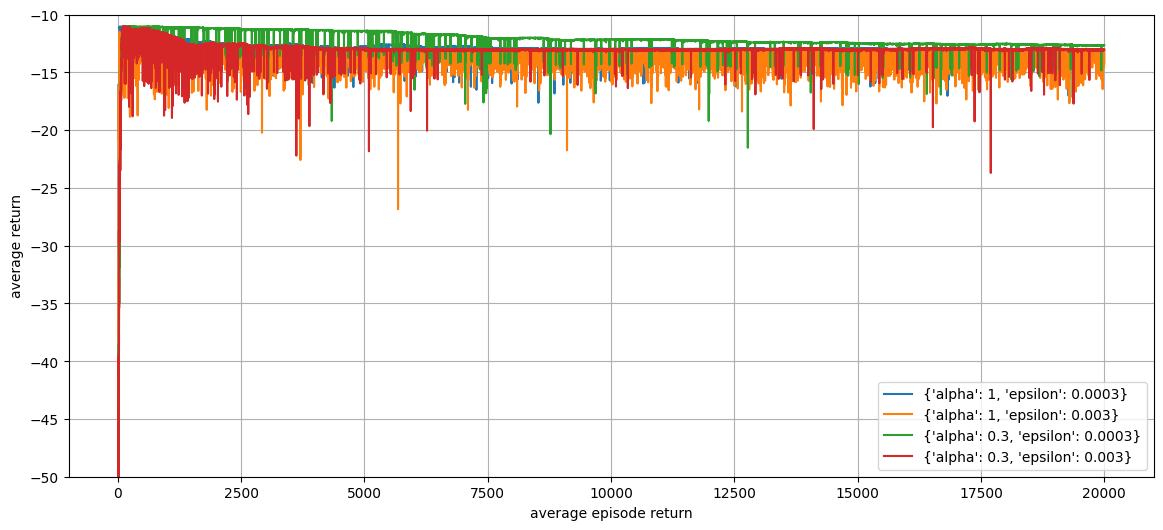

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))

for k, v in results.items():
    ax.plot(v[0], label=k)

ax.grid()
ax.legend(loc="lower right")
ax.set(xlabel="average episode return", ylabel="average return", ylim = [-50, -10])

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

for k, v in results.items():
    ax.plot(v[0], label=k)

ax.grid()
ax.legend(loc="upper right")
ax.set(xlabel="# of episodes", ylabel="average length", ylim = [0, 50])

plt.show()

# Small Worlds

For simplicity lets restric our search to a smaller set of hyperparameters. These should still be enough to get a good idea of what is goind on.

In [5]:
training_rounds=10
episodes=200
arguments = {'alpha': [0.3, 0.7, 1], 'epsilon': [0.0003, 0.001, 0.003]}

print(get_world_str(small_world_01))

3               

2          █    

1    █     ☠    

0 ⚐  █        ✘ 

  0  1  2  3  4 


In [6]:
e_arguments = {'world': small_world_01, 'reward_function': basic_reward, 'actions': basic_actions}

results = get_exp_results(SarsaAgent, base_arguments, arguments, episodes, training_rounds) 

average_lengths_l10 = {key: (np.mean(results[key][1][-10:]))for key in results}
average_lengths = {key: (np.mean(results[key][1]))for key in results}

print("Average reward on rounds")
for k, v in sorted(average_lengths.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.2f}")

print("\nAverage reward on last 10 episodes")
for k, v in sorted(average_lengths_l10.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.2f}")

Average training rounds length
{'alpha': 1, 'epsilon': 0.0003}: -28.89
{'alpha': 1, 'epsilon': 0.001}: -29.06
{'alpha': 0.7, 'epsilon': 0.0003}: -30.14
{'alpha': 0.7, 'epsilon': 0.001}: -30.45
{'alpha': 1, 'epsilon': 0.003}: -30.58
{'alpha': 0.7, 'epsilon': 0.003}: -31.77
{'alpha': 0.3, 'epsilon': 0.001}: -35.26
{'alpha': 0.3, 'epsilon': 0.0003}: -35.31
{'alpha': 0.3, 'epsilon': 0.003}: -36.36

Average length on last 10 episodes
{'alpha': 0.3, 'epsilon': 0.0003}: -11.00
{'alpha': 1, 'epsilon': 0.0003}: -11.00
{'alpha': 0.3, 'epsilon': 0.001}: -11.09
{'alpha': 0.7, 'epsilon': 0.0003}: -11.20
{'alpha': 0.3, 'epsilon': 0.003}: -11.22
{'alpha': 1, 'epsilon': 0.001}: -11.40
{'alpha': 0.7, 'epsilon': 0.001}: -11.52
{'alpha': 0.7, 'epsilon': 0.003}: -12.50
{'alpha': 1, 'epsilon': 0.003}: -13.68


In [7]:
print(get_world_str(small_world_02))

4               

3          █    

2          █    

1    █     ☠  ✘ 

0 ⚐  █          

  0  1  2  3  4 


In [8]:
e_arguments = {'world': small_world_02, 'reward_function': basic_reward, 'actions': basic_actions}

results = get_exp_results(SarsaAgent, base_arguments, arguments, episodes, training_rounds) 

average_lengths_l10 = {key: (np.mean(results[key][1][-10:]))for key in results}
average_lengths = {key: (np.mean(results[key][1]))for key in results}

print("Average reward on rounds")
for k, v in sorted(average_lengths.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.2f}")

print("\nAverage reward on last 10 episodes")
for k, v in sorted(average_lengths_l10.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.2f}")

Average training rounds length
{'alpha': 1, 'epsilon': 0.0003}: -28.92
{'alpha': 1, 'epsilon': 0.001}: -29.55
{'alpha': 1, 'epsilon': 0.003}: -29.83
{'alpha': 0.7, 'epsilon': 0.0003}: -30.02
{'alpha': 0.7, 'epsilon': 0.001}: -30.85
{'alpha': 0.7, 'epsilon': 0.003}: -31.23
{'alpha': 0.3, 'epsilon': 0.0003}: -35.20
{'alpha': 0.3, 'epsilon': 0.001}: -35.55
{'alpha': 0.3, 'epsilon': 0.003}: -35.70

Average length on last 10 episodes
{'alpha': 0.3, 'epsilon': 0.0003}: -11.00
{'alpha': 1, 'epsilon': 0.0003}: -11.00
{'alpha': 0.3, 'epsilon': 0.001}: -11.02
{'alpha': 0.3, 'epsilon': 0.003}: -11.16
{'alpha': 0.7, 'epsilon': 0.0003}: -11.48
{'alpha': 1, 'epsilon': 0.001}: -11.60
{'alpha': 0.7, 'epsilon': 0.001}: -11.82
{'alpha': 0.7, 'epsilon': 0.003}: -12.31
{'alpha': 1, 'epsilon': 0.003}: -12.45


# Large World

In [9]:
print(get_world_str(large_world_01))

7 █  █  █  █  █                

6                   █  █  █    

5    █  █     █  █  ✘     █    

4                █             

3    █     █  █  █  █     █  █ 

2    █              █          

1    █     ☠  ☠     █        ☠ 

0 ⚐        █                   

  0  1  2  3  4  5  6  7  8  9 


In [10]:
base_arguments = {'world': large_world_01, 'reward_function': basic_reward, 'actions': basic_actions}

results = get_exp_results(SarsaAgent, base_arguments, arguments, episodes, training_rounds) 

average_lengths_l10 = {key: (np.mean(results[key][1][-10:]))for key in results}
average_lengths = {key: (np.mean(results[key][1]))for key in results}

print("Average reward on rounds")
for k, v in sorted(average_lengths.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.2f}")

print("\nAverage reward on last 10 episodes")
for k, v in sorted(average_lengths_l10.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.2f}")

Average training rounds length
{'alpha': 1, 'epsilon': 0.0003}: -41.15
{'alpha': 1, 'epsilon': 0.001}: -42.26
{'alpha': 0.7, 'epsilon': 0.0003}: -43.08
{'alpha': 1, 'epsilon': 0.003}: -43.40
{'alpha': 0.7, 'epsilon': 0.003}: -43.62
{'alpha': 0.7, 'epsilon': 0.001}: -44.00
{'alpha': 0.3, 'epsilon': 0.0003}: -60.49
{'alpha': 0.3, 'epsilon': 0.001}: -60.77
{'alpha': 0.3, 'epsilon': 0.003}: -60.81

Average length on last 10 episodes
{'alpha': 0.3, 'epsilon': 0.0003}: -17.00
{'alpha': 0.7, 'epsilon': 0.0003}: -17.06
{'alpha': 0.3, 'epsilon': 0.003}: -17.09
{'alpha': 0.3, 'epsilon': 0.001}: -18.52
{'alpha': 0.7, 'epsilon': 0.001}: -18.60
{'alpha': 1, 'epsilon': 0.001}: -19.32
{'alpha': 1, 'epsilon': 0.0003}: -19.70
{'alpha': 0.7, 'epsilon': 0.003}: -20.08
{'alpha': 1, 'epsilon': 0.003}: -20.51


In [11]:
agent = SarsaAgent(
    world=large_world_01,
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=1,
    epsilon=0.0003,
)

episode_lengths, episode_returns = agent.train(episodes=200)
pi_r = get_policy_rec(agent.policy, large_world_01, agent.actions)
print(get_policy_rec_str(pi_r, large_world_01))

 █  █  █  █  █  →  →  →  →  ↓ 

 →  →  ↑  →  →  ↑  █  █  █  ↓ 

 ↑  █  █  ↑  █  █  ✘  ←  █  ↓ 

 →  ↑  →  ←  →  █  ↑  ↑  ←  ← 

 ↑  █  ↓  █  █  █  █  ↑  █  █ 

 ↑  █  →  →  →  ↓  █  ↑  ←  → 

 ←  █  ↑  ☠  ☠  ↓  █  ↑  ↓  ☠ 

 →  →  ↑  █  ↓  →  →  ↑  ↓  → 




In [18]:
agent = SarsaAgent(
    world=large_world_01,
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=1,
    epsilon=0.0003,
)

episode_lengths, episode_returns = agent.train(episodes=50000)
pi_r = get_policy_rec(agent.policy, large_world_01, agent.actions)
print(get_policy_rec_str(pi_r, large_world_01))

 █  █  █  █  █  →  →  →  →  ↓ 

 →  →  →  →  →  ↑  █  █  █  ↓ 

 ↑  █  █  ↑  █  █  ✘  ←  █  ↓ 

 ↑  →  →  ↑  →  █  ↑  ↑  ←  ← 

 ↑  █  ↓  █  █  █  █  ↑  █  █ 

 ↑  █  ↓  →  →  ↓  █  ↑  ↑  → 

 ↑  █  ←  ☠  ☠  ↓  █  ↑  ↑  ☠ 

 ↑  →  →  █  ↓  →  →  ↑  ↑  → 


